#### Ingest Data

In [167]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

In [168]:
data = pd.read_csv('movieReplicationSet.csv') # ingest the data in one line
data = data.apply(pd.to_numeric, errors='coerce') # makes sure all strings are converted to floats
data.replace('', np.nan, inplace=True) # convert empty values to NaN

In [169]:
# # check if there's empty values
# empty_cells = data.eq('')
# empty_count = empty_cells.sum().sum()  # Sum twice: once for columns and once for rows
# non_empty_count = data.size - empty_count  # total cells minus empty cells

# print(f"Number of empty cells: {empty_count}")
# print(f"Number of non-empty cells: {non_empty_count}")

In [170]:
data

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching,Gender identity (1 = female; 2 = male; 3 = self-described),Are you an only child? (1: Yes; 0: No; -1: Did not respond),Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,1.0,6.0,2.0,5.0,5.0,5.0,1.0,1.0,0,1
1,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,1.0,6.0,5.0,3.0,2.0,1.0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,1,0
3,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,4.0,...,3.0,1.0,1.0,4.0,5.0,3.0,1.0,1.0,0,1
4,NaN,NaN,3.5,NaN,0.5,NaN,0.5,1.0,NaN,0.0,...,2.0,3.0,2.0,5.0,6.0,4.0,4.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,0,0
1093,3.0,4.0,NaN,NaN,4.0,4.0,2.5,NaN,3.5,3.5,...,5.0,3.0,5.0,5.0,5.0,6.0,5.0,1.0,0,0
1094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,...,6.0,3.0,1.0,6.0,6.0,4.0,2.0,1.0,0,0
1095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,4.0,3.0,3.0,1.0,1.0,0,1


#### Q1
Are movies that are more popular (operationalized as having more ratings) rated higher than movies that are less popular? [Hint: You can do a median-split of popularity to determine high vs. low popularity movies] 

In [64]:
## Handling the data
# 1. Calculate popularity (non-NaN count) for each movie
popularity = data.iloc[:, 0:400].count()

# 2. Determine the median popularity
median_popularity = popularity.median()

# 3. Split movies into high and low popularity groups
high_popularity_indices = popularity[popularity > median_popularity].index
low_popularity_indices = popularity[popularity <= median_popularity].index

# 4. Get average ratings for each movie
# pandas will skip NaN for aggregate values
average_ratings = data.iloc[:, 0:400].mean()

# 5. Extract average ratings for high and low popularity movies
high_popularity_ratings = average_ratings.loc[high_popularity_indices]
low_popularity_ratings = average_ratings.loc[low_popularity_indices]

In [36]:
## Check if the 2 groups (high popularity, low popularity) have equal variance

# Convert the Pandas Series to lists
high_popularity_ratings_list = high_popularity_ratings.tolist()
low_popularity_ratings_list = low_popularity_ratings.tolist()

# Conduct the Levene test
result = pg.homoscedasticity(data=[high_popularity_ratings_list, low_popularity_ratings_list], method='levene')
print(result)

               W      pval  equal_var
levene  12.92466  0.000365      False


In [42]:
## 4. Conduct Welch-T-test

# Welch's T-test
t_stat, p_val = stats.ttest_ind(high_popularity_ratings, low_popularity_ratings, equal_var=False)

print(f"Welch's T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.3f}")

# Finding df
# Calculate variances
s1_sq = np.var(high_popularity_ratings, ddof=1)
s2_sq = np.var(low_popularity_ratings, ddof=1)

# Calculate sample sizes
n1 = len(high_popularity_ratings)
n2 = len(low_popularity_ratings)

# Compute degrees of freedom for Welch's t-test
numerator = ((s1_sq / n1) + (s2_sq / n2))**2
denominator = ((s1_sq / n1)**2 / (n1 - 1)) + ((s2_sq / n2)**2 / (n2 - 1))

df_welch = numerator / denominator

print(f"df: {df_welch:.3f}")

Welch's T-statistic: 17.756
P-value: 0.000
df: 378.536


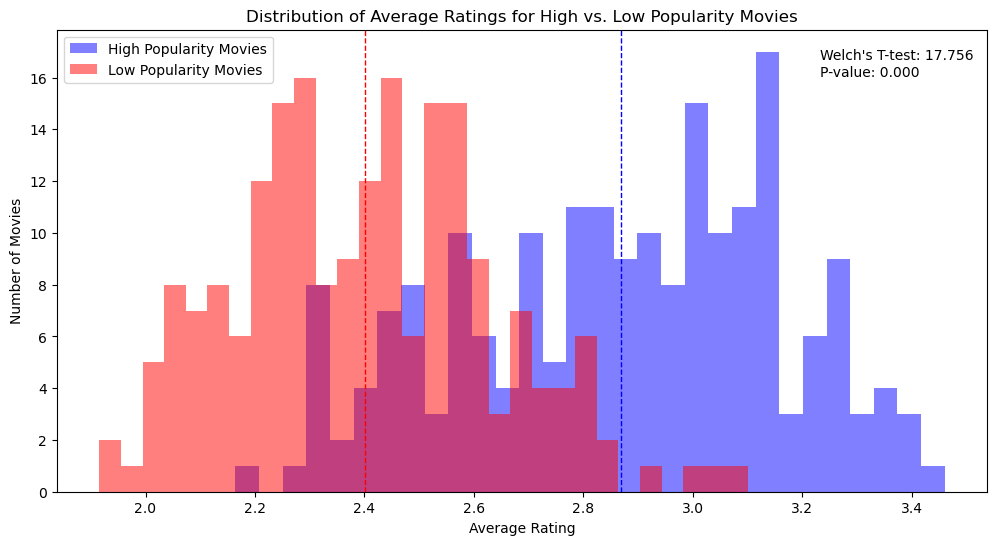

In [35]:
# Plot histograms of ratings
plt.figure(figsize=(12, 6))
plt.hist(high_popularity_ratings, bins=30, alpha=0.5, label="High Popularity Movies", color="blue")
plt.hist(low_popularity_ratings, bins=30, alpha=0.5, label="Low Popularity Movies", color="red")

# Add vertical lines for means
plt.axvline(high_popularity_ratings.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(low_popularity_ratings.mean(), color='red', linestyle='dashed', linewidth=1)

# Annotate with t-test results
plt.text(0.82, 0.9, f'Welch\'s T-test: {t_stat:.3f}\nP-value: {p_val:.3f}', transform=plt.gca().transAxes)

# Add title and labels
plt.title("Distribution of Average Ratings for High vs. Low Popularity Movies")
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.legend()
plt.show()

In [13]:
# data type: pandas.core.series.Series
popularity

The Life of David Gale (2003)                 76
Wing Commander (1999)                         71
Django Unchained (2012)                      453
Alien (1979)                                 289
Indiana Jones and the Last Crusade (1989)    463
                                            ... 
Patton (1970)                                 61
Anaconda (1997)                              198
Twister (1996)                               174
MacArthur (1977)                              61
Look Who's Talking (1989)                    108
Length: 400, dtype: int64

In [14]:
median_popularity

197.5

In [15]:
type(high_popularity_indices)

pandas.core.indexes.base.Index

In [16]:
# data type: pandas.core.series.Series
high_popularity_ratings

Django Unchained (2012)                           3.153422
Alien (1979)                                      2.707612
Indiana Jones and the Last Crusade (1989)         2.778618
Fargo (1996)                                      2.899606
Black Swan (2010)                                 2.911565
                                                    ...   
X-Men 2 (2003)                                    2.914062
The Mask (1994)                                   2.559045
Jaws (1975)                                       2.618952
Harry Potter and the Chamber of Secrets (2002)    3.272459
Anaconda (1997)                                   2.295455
Length: 200, dtype: float64

In [17]:
## Check what's inside the high_popularity_indice and the # of the ratings
# Create an empty list to store the results
high_popularity_movies = []

# Loop through the high_popularity_indices
for movie_name in high_popularity_indices:
    # Get the number of ratings for the movie
    num_ratings = popularity[movie_name]
    
    # Append the movie name and its ratings count to the list
    high_popularity_movies.append((movie_name, num_ratings))

# Convert the list to a DataFrame
high_popularity_df = pd.DataFrame(high_popularity_movies, columns=['Movie_Name', 'Number_of_Ratings'])


sorted_high_popularity_df = high_popularity_df.sort_values(by='Number_of_Ratings', ascending=False)

print(sorted_high_popularity_df)


                              Movie_Name  Number_of_Ratings
63                   Finding Nemo (2003)               1014
48                          Shrek (2001)               1008
35                        Shrek 2 (2004)                965
110                 The Lion King (1994)                937
136                 Monsters  Inc.(2001)                927
..                                   ...                ...
155                Reservoir Dogs (1992)                203
184      My Best Friend's Wedding (1997)                202
132  There's Something About Mary (1998)                202
175                     Halloween (1978)                201
199                      Anaconda (1997)                198

[200 rows x 2 columns]


In [18]:
# Create an empty list to store the results
low_popularity_movies = []

# Loop through the low_popularity_indices
for movie_name in low_popularity_indices:
    # Get the number of ratings for the movie
    num_ratings = popularity[movie_name]
    
    # Append the movie name and its ratings count to the list
    low_popularity_movies.append((movie_name, num_ratings))

# Convert the list to a DataFrame
low_popularity_df = pd.DataFrame(low_popularity_movies, columns=['Movie_Name', 'Number_of_Ratings'])


sorted_low_popularity_df = low_popularity_df.sort_values(by='Number_of_Ratings', ascending=False)

print(sorted_low_popularity_df)

                       Movie_Name  Number_of_Ratings
107         Knight and Day (2010)                197
127  Ouija: Origin of Evil (2016)                197
144              The Visit (2015)                196
168        The Transporter (2002)                193
195     The Usual Suspects (1995)                193
..                            ...                ...
71              Stir Crazy (1980)                 59
54              Sexy Beast (2000)                 56
171             FeardotCom (2002)                 56
166     The Final Conflict (1981)                 55
122        Best Laid Plans (1999)                 54

[200 rows x 2 columns]


<Axes: ylabel='Frequency'>

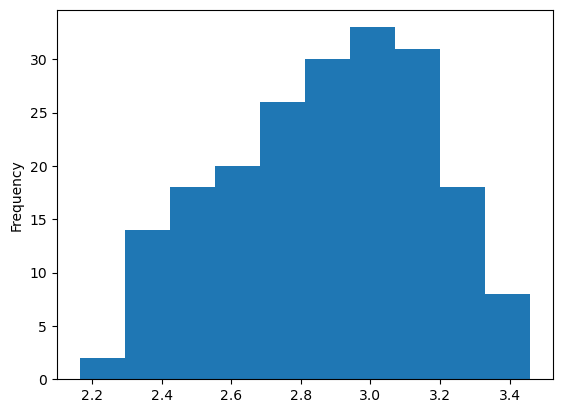

In [19]:
high_popularity_ratings.plot(kind='hist')

<Axes: ylabel='Frequency'>

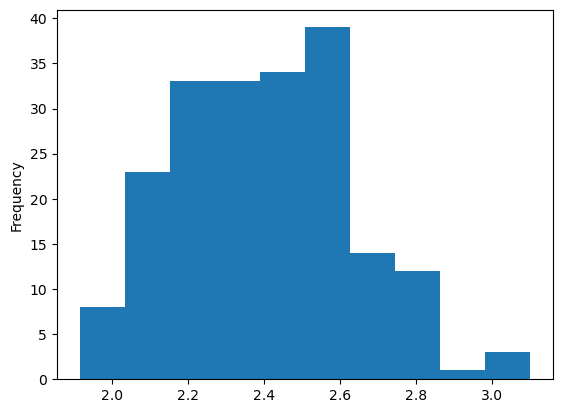

In [20]:
low_popularity_ratings.plot(kind='hist')

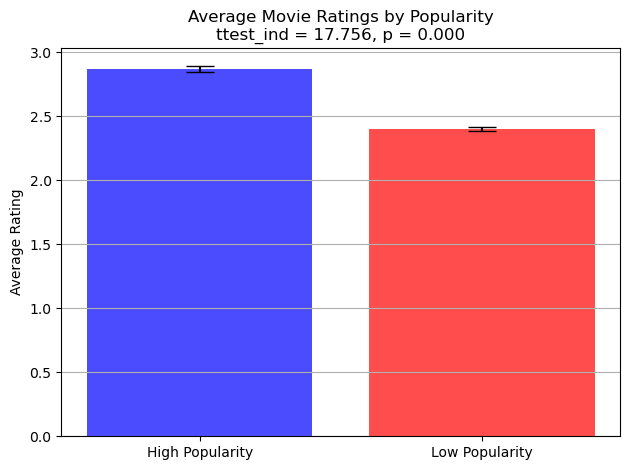

In [21]:
# Calculate means and standard errors
mean_high = high_popularity_ratings.mean()
mean_low = low_popularity_ratings.mean()

sem_high = high_popularity_ratings.std() / np.sqrt(len(high_popularity_ratings))
sem_low = low_popularity_ratings.std() / np.sqrt(len(low_popularity_ratings))

# Plotting
labels = ['High Popularity', 'Low Popularity']
means = [mean_high, mean_low]
errors = [sem_high, sem_low]

plt.bar(labels, means, yerr=errors, color=['blue', 'red'], alpha=0.7, capsize=10)
plt.ylabel('Average Rating')
plt.title('Average Movie Ratings by Popularity\n' + 'ttest_ind = {:.3f}'.format(t_stat) + ', p = {:.3f}'.format(p_val))
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()


#### Q2
Are movies that are newer rated differently than movies that are older? [Hint: Do a median split of year of release to contrast movies in terms of whether they are old or new]

In [205]:
import re
## Handling the data
# 1. Calculate popularity (non-NaN count) for each movie
movie_titles = data.columns[:400]
year_list = [int(re.search(r"\((\d{4})\)", title).group(1)) if re.search(r"\((\d{4})\)", title) else None for title in data.columns[:400]]
year = pd.Series(year_list, index=movie_titles)


# 2. Determine the median year
median_year = year.median()

# 3. Split movies into new and old movie groups
new_movies_indices = year[year > median_year].index
old_movies_indices = year[year <= median_year].index

# 4. Get average ratings for each movie
average_ratings = data.iloc[:, 0:400].mean()

# 5. Extract average ratings for new and old movie groups
new_movies_ratings = average_ratings.loc[new_movies_indices]
old_movies_ratings = average_ratings.loc[old_movies_indices]

In [209]:
## Check if the 2 groups (high popularity, low popularity) have equal variance

# Convert the Pandas Series to lists
new_movies_ratings_list = new_movies_ratings.tolist()
old_movies_ratings_list = old_movies_ratings.tolist()

# Conduct the Levene test
result = pg.homoscedasticity(data=[new_movies_ratings_list, old_movies_ratings_list], method='levene')
print(result)

               W     pval  equal_var
levene  0.684462  0.40855       True


In [216]:
## 4. Conduct Independent-T-test

# Independent-T-test
t_stat, p_val = stats.ttest_ind(new_movies_ratings, old_movies_ratings)

# Calculate df
df = len(new_movies_ratings) + len(old_movies_ratings) - 2

print(f"Independent T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.3f}")
print("df = " + str(df))

Independent T-statistic: 1.124
P-value: 0.262
df = 398


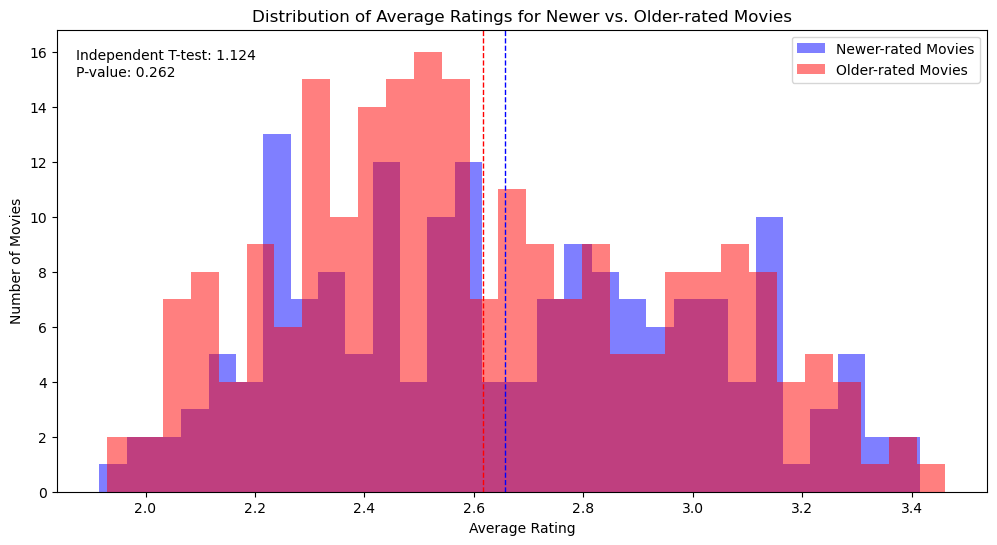

In [220]:
# Plot histograms of ratings
plt.figure(figsize=(12, 6))
plt.hist(new_movies_ratings, bins=30, alpha=0.5, label="Newer-rated Movies", color="blue")
plt.hist(old_movies_ratings, bins=30, alpha=0.5, label="Older-rated Movies", color="red")

# Add vertical lines for means
plt.axvline(new_movies_ratings.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(old_movies_ratings.mean(), color='red', linestyle='dashed', linewidth=1)

# Annotate with t-test results
plt.text(0.02, 0.9, f'Independent T-test: {t_stat:.3f}\nP-value: {p_val:.3f}', transform=plt.gca().transAxes)

# Add title and labels
plt.title("Distribution of Average Ratings for Newer vs. Older-rated Movies")
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.legend()
plt.show()

In [206]:
year

The Life of David Gale (2003)                2003
Wing Commander (1999)                        1999
Django Unchained (2012)                      2012
Alien (1979)                                 1979
Indiana Jones and the Last Crusade (1989)    1989
                                             ... 
Patton (1970)                                1970
Anaconda (1997)                              1997
Twister (1996)                               1996
MacArthur (1977)                             1977
Look Who's Talking (1989)                    1989
Length: 400, dtype: int64

In [207]:
median_year

1999.0

In [208]:
## Check what's inside the new_movies_indices and the year of the movie
# Create an empty list to store the results
new_movies = []

# Loop through the new_movies_indices
for movie_name in new_movies_indices:
    # Get the number of ratings for the movie
    year_of_the_movie = year[movie_name]
    
    # Append the movie name and its ratings count to the list
    new_movies.append((movie_name, year_of_the_movie))

# Convert the list to a DataFrame
year_df = pd.DataFrame(new_movies, columns=['Movie_Name', 'Year_of_Movie'])


sorted_year_df = year_df.sort_values(by='Year_of_Movie', ascending=False)

print(sorted_year_df)

                            Movie_Name  Year_of_Movie
87                        Split (2016)           2016
161  Captain America: Civil War (2016)           2016
106       Ouija: Origin of Evil (2016)           2016
56                 Ghostbusters (2016)           2016
137                  La La Land (2016)           2016
..                                 ...            ...
139            Meet the Parents (2000)           2000
50                        X-Men (2000)           2000
57                Almost Famous (2000)           2000
148                 Scary Movie (2000)           2000
144                   Cast Away (2000)           2000

[174 rows x 2 columns]


In [61]:
## Check what's inside the old_movies_indices and the year of the movie
# Create an empty list to store the results
old_movies = []

# Loop through the new_movies_indices
for movie_name in old_movies_indices:
    # Get the number of ratings for the movie
    year_of_the_movie = year[movie_name]
    
    # Append the movie name and its ratings count to the list
    old_movies.append((movie_name, year_of_the_movie))

# Convert the list to a DataFrame
year_df = pd.DataFrame(old_movies, columns=['Movie_Name', 'Year_of_Movie'])


sorted_year_df = year_df.sort_values(by='Year_of_Movie', ascending=False)

print(sorted_year_df)

                                Movie_Name  Year_of_Movie
0                    Wing Commander (1999)           1999
184                  The Green Mile (1999)           1999
175                 Double Jeopardy (1999)           1999
51                       Fight Club (1999)           1999
165              The Straight Story (1999)           1999
..                                     ...            ...
156        Thoroughly Modern Millie (1967)           1967
99   Who's Afraid of Virginia Woolf (1966)           1966
73    The Good the Bad and the Ugly (1966)           1966
84                    The Silencers (1966)           1966
10                           Psycho (1960)           1960

[226 rows x 2 columns]


#### Q7
Do people who like to watch movies socially enjoy ‘The Wolf of Wall Street (2013)’ more than those who prefer to watch them alone?

In [120]:
## Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
# Remove NaN and -1 values from 
filtered_data = data[data['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'].isin([0, 1])]

# Split data based on watching preference
watch_alone = filtered_data[filtered_data['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 1]
watch_together = filtered_data[filtered_data['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 0]

In [121]:
## Handling the Data: Element-wise elimination for WoWS

# warch alone, len=393
WoWS_watch_alone = WoWS_watch_alone[np.isfinite(watch_alone['The Wolf of Wall Street (2013)'])]

# watch together, len=270
WoWS_watch_together = WoWS_watch_together[np.isfinite(watch_together['The Wolf of Wall Street (2013)'])] 

In [180]:
## Check if the 2 groups (WoWS_watch_alone, WoWS_watch_together) have equal variance

# Convert the Pandas Series to lists
WoWS_watch_alone_list = WoWS_watch_alone.tolist()
WoWS_watch_together_list = WoWS_watch_together.tolist()

# Conduct the Levene test
result = pg.homoscedasticity(data=[WoWS_watch_alone_list, WoWS_watch_together_list], method='levene')
print(result)

               W     pval  equal_var
levene  0.805503  0.36978       True


In [132]:
## Conduct the independent t-test

WoWS_t_stat, WoWS_p_value = stats.ttest_ind(WoWS_watch_alone, WoWS_watch_together)

print(f"T-statistic: {WoWS_t_stat:.3f}")
print(f"P-value: {WoWS_p_value:.3f}")


# degrees of freedom (N1 + N2 - 2):
df = (len(WoWS_watch_alone) + len(WoWS_watch_together) - 2)
print("df = " + str(df))

T-statistic: 1.568
P-value: 0.117
df = 661


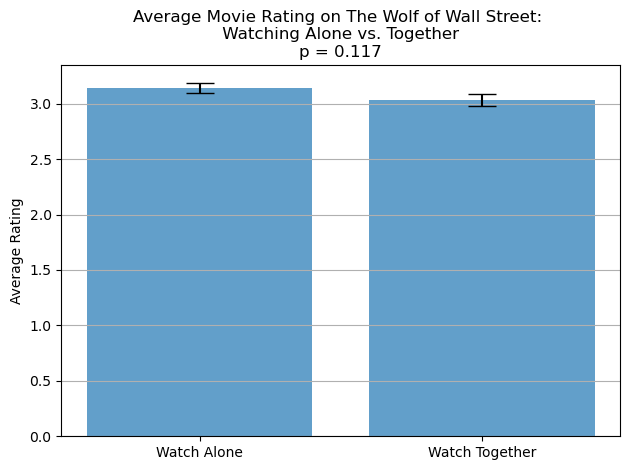

In [127]:
## Plotting

# Compute means
mean_alone = np.mean(WoWS_watch_alone)
mean_together = np.mean(WoWS_watch_together)

# Compute standard errors
sem_alone = np.std(WoWS_watch_alone, ddof=1) / np.sqrt(len(WoWS_watch_alone))
sem_together = np.std(WoWS_watch_together, ddof=1) / np.sqrt(len(WoWS_watch_together))

# Plotting
labels = ['Watch Alone', 'Watch Together']
means = [mean_alone, mean_together]
errors = [sem_alone, sem_together]

fig, ax = plt.subplots()
ax.bar(labels, means, yerr=errors, align='center', alpha=0.7, ecolor='black', capsize=10)
ax.set_ylabel('Average Rating')
ax.set_title('Average Movie Rating on The Wolf of Wall Street: \n Watching Alone vs. Together \n' + 'p = {:.3f}'.format(WoWS_p_value))
ax.yaxis.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


In [153]:
# check no NaN values
print(type(WoWS_watch_alone))
print(WoWS_watch_alone.isna().any())
print(WoWS_watch_together.isna().any())

<class 'pandas.core.series.Series'>
False
False


In [95]:
WoWS_watch_together

5       2.5
6       1.0
12      3.5
14      4.0
18      4.0
       ... 
1082    4.0
1085    4.0
1087    4.0
1093    3.5
1094    2.0
Name: The Wolf of Wall Street (2013), Length: 270, dtype: float64

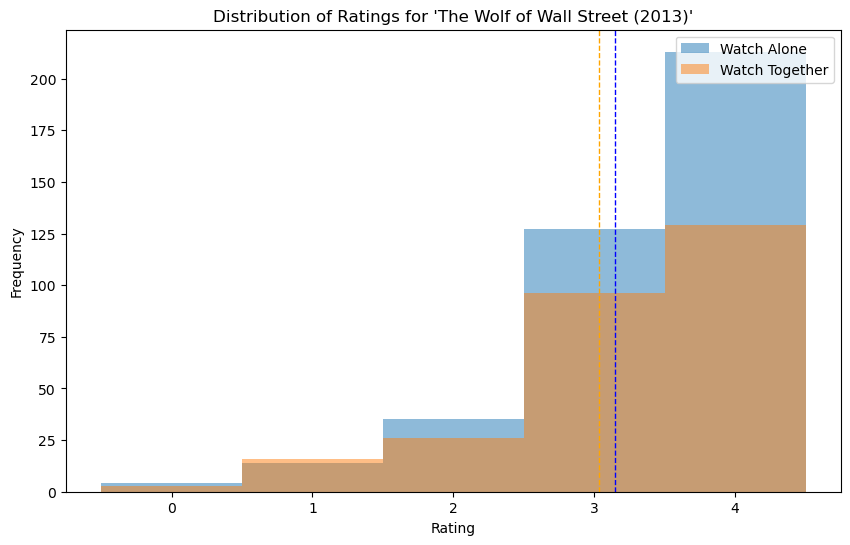

In [128]:
## Plotting

# Compute means
mean_alone = np.mean(WoWS_watch_alone)
mean_together = np.mean(WoWS_watch_together)

# Plotting histograms
plt.figure(figsize=(10, 6))
plt.hist(WoWS_watch_alone, bins=np.arange(-0.5, 5.5, 1), alpha=0.5, label='Watch Alone')
plt.hist(WoWS_watch_together, bins=np.arange(-0.5, 5.5, 1), alpha=0.5, label='Watch Together')

# Plotting means
plt.axvline(mean_alone, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_together, color='orange', linestyle='dashed', linewidth=1)

# Adding legends and labels
plt.legend(loc='upper right')
plt.title("Distribution of Ratings for 'The Wolf of Wall Street (2013)'")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 5, 1))  # Assuming ratings are whole numbers from 0 to 4

plt.show()

#### Q8
What proportion of movies exhibit such a “social watching” effect?

In [175]:
## Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
# Remove NaN and -1 values from 
filtered_data = data[data['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'].isin([0, 1])]

# Split data based on watching preference
watch_alone_data = filtered_data[filtered_data['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 1]
watch_together_data = filtered_data[filtered_data['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 0]

In [203]:
significance_cnt = 0
t_dic = { "movie": "p-value"}
w_dic = { "movie": "p-value"}
res_dic = { "movie": "p-value"}


for i in filtered_data.columns[0:400]:
    
    # do element-wise elimination for all movies
    alone_ratings = watch_alone_data[i].dropna()
    together_ratings = watch_together_data[i].dropna()
    
    # print(i + "   " +  str(len(alone_ratings)) + "   " + str(len(together_ratings)))
    
    
    # check variance, conduct the Levene test
    alone_ratings_list = alone_ratings.tolist()
    together_ratings_list = together_ratings.tolist()
    result = pg.homoscedasticity(data=[alone_ratings_list, together_ratings_list], method='levene')
    
    
    # decide what t-test to run
    
    if (result.iloc[0,2]) == True: 
        # run independent t-test
        all_t_stat, all_p_value = stats.ttest_ind(alone_ratings, together_ratings)
        # t_dic[i] ='{:.3f}'.format(all_p_value)
    else:
        # run welch t-test
        all_t_stat, all_p_value = stats.ttest_ind(alone_ratings, together_ratings, equal_var=False)
        # w_dic[i] ='{:.3f}'.format(all_p_value)
    
    # check significance (𝛼 = 0.005)
    if all_p_value < 0.005:
        significance_cnt += 1
        res_dic[i] ='{:.3f}'.format(all_p_value)

print(significance_cnt)
print(res_dic)
# print("\n\n\n\nt_dic")
# print(t_dic)
# print("\n\n\n\nW_dic")
# print(w_dic)
    

6
{'movie': 'p-value', 'The Silence of the Lambs (1991)': '0.003', 'North (1994)': '0.003', 'Shrek 2 (2004)': '0.001', 'Ghostbusters (2016)': '0.004', 'Spider-Man (2002)': '0.003', 'Donnie Darko (2001)': '0.001'}
